In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

Npts=30 #maximum 69 points


#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1_array = np.asarray(v_err1)
#Express as weights
weighdata = (1/v_err1)

print(r_dat[:Npts])
print(v_dat[:Npts])

[0.2878 0.597  0.8822 1.1891 1.4729 1.7774 2.0881 2.3948 2.6781 2.9841
 3.2661 3.6217 3.8815 4.2093 4.5053 4.7997 5.107  5.3826 5.6779 5.9822
 6.2878 6.5819 7.1813 7.4915 7.7668 7.8817 8.0835 8.3921 8.6851 9.289 ]
[297.1629 286.2967 276.7923 276.8658 274.8824 286.5792 268.192  269.6329
 269.7008 274.5603 281.4654 274.7128 274.0913 288.5287 283.8132 287.6444
 286.0085 265.5617 264.9485 278.3547 285.6073 290.4641 304.6246 288.2886
 269.2091 285.305  279.8832 270.7263 282.0785 273.3341]


In [3]:
# Function for fitting all parameters (n, re, h)
#def f(r,M,rc,rho00,c,n,re,h,pref):
#    return np.sqrt(nf.bh_v(r,M)**2 
#                   + nf.h_v(r,rc,rho00,load=True)**2 
#                   + c**2*nf.b_v(r,n,reload=True)**2 
#                   + nf.d_v(r,h,pref,load=True)**2)

# Function for fitting only prefactors + halo's parameters
def g(r,M,rc,rho00,c,pref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=False)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_v(r,load=True)**2)

print(g(1,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))
print(g(5,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))

[292.4325997]
[347.13118127]


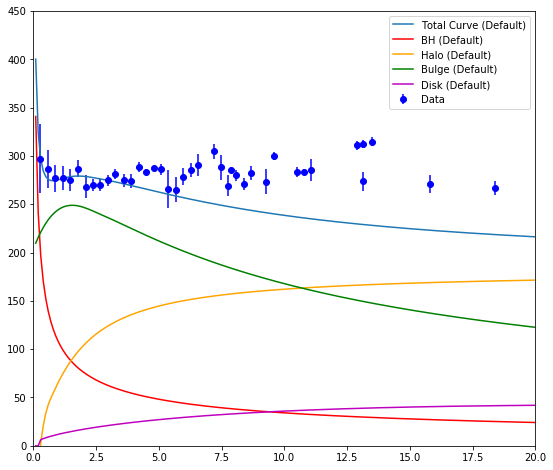

In [4]:
#Plot 

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,20)
plt.ylim(0,450)

rval = np.arange(0.1,200,0.1)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,0.1),label='Total Curve (Default)')
plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='BH (Default)')
plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Halo (Default)')
plt.plot(rval,nf.b_v(rval,load=True),color='g',label='Bulge (Default)')
plt.plot(rval,0.1*nf.d_v(rval,load=True),color='m',label='Disk (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [5]:
# Fit, using all parameters

#Setup
#l_mod = lm.Model(f)
#l_params = l_mod.make_params()
#Black Hole
#l_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
#l_params.add('c', value=1, min=0)          #Contributions should all add
#l_params.add('n', value=nf.n_c, min=0)
#l_params.add('re', value=nf.re_c, min=0)
#Disk
#l_params.add('pref', value=nf.pref_def, min=0, max=1000)
#l_params.add('h', value=nf.h_c, min=0, max=1000)
#Halo
#l_params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
#l_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Do fit
#l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [6]:
# Fit, using prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=1.0e8, vary=True) #Mass
#Halo
g_params.add('rc', value=nf.h_rc, min=0.1, vary=False)   #Radius (magnitude)
g_params.add('rho00', value=nf.hrho00_c, min=0, vary=True) #Density (halo)

#Bulge
g_params.add('c', value=1,min=0,max=100, vary=True)          #Contributions should all add
#Disk
#g_params.add('pref', value=0.1,min=0, max=100, vary=True)
g_params.add('pref', value=0.0,min=0, max=100, vary=False)

#Do fit
g_fit = g_mod.fit(v_dat[:Npts],g_params,r=r_dat[:Npts],weights=weighdata[:Npts])

In [7]:
#Define for plotting

bestg = g_fit.best_fit
delg = g_fit.eval_uncertainty()

In [8]:
#print('Fit information for all-component fit, no prefactor:')
#l_fit

In [9]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


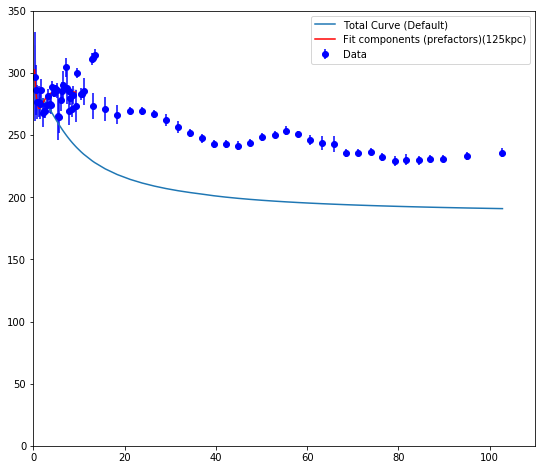

In [10]:
#Plot to 110kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,110)
plt.ylim(0,350)


plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (125kpc)')
plt.plot(r_dat,g(r_dat,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,0.1),label='Total Curve (Default)')
plt.plot(r_dat[:Npts],bestg,'r-',label='Fit components (prefactors)(125kpc)')
plt.fill_between(r_dat[:Npts],bestg-delg,bestg+delg,color='#dddddd')

plt.legend()
plt.savefig('ANV_Fitting_allcomponents_125kpc.png')
plt.show()

In [11]:
#Define for plotting cont.

g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_pref = g_dict['pref']
g_rc = g_dict['rc']
g_hrho00 = g_dict['rho00']


r_plot = np.linspace(0.1,r_dat[Npts-1],100)
g_curve = g(r_plot,g_M,g_rc,g_hrho00,g_c,g_pref)
bh_curve = nf.bh_v(r_plot,g_M)
halo_curve = nf.h_v(r_plot,g_rc,g_hrho00)
bulge_curve = g_c*nf.b_v(r_plot)
disk_curve = g_pref*nf.d_v(r_plot)

r_plot_zoom = np.linspace(0.1,120,100)
g_curve_zoom = g(r_plot_zoom,g_M,g_rc,g_hrho00,g_c,g_pref)
bh_curve_zoom = nf.bh_v(r_plot_zoom,g_M)
halo_curve_zoom = nf.h_v(r_plot_zoom,g_rc,g_hrho00)
bulge_curve_zoom = g_c*nf.b_v(r_plot_zoom)
disk_curve_zoom = g_pref*nf.d_v(r_plot_zoom)

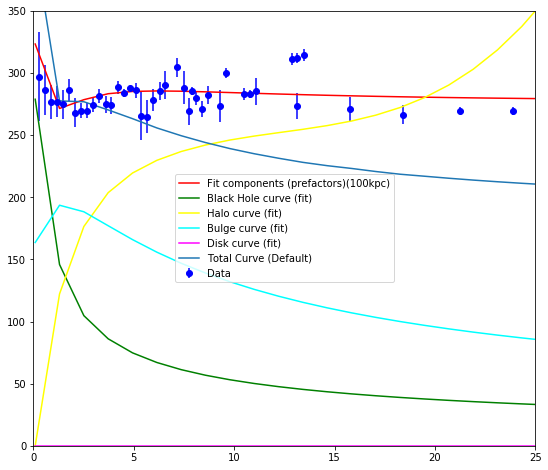

In [12]:
#Plot each fitted component to 25kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(r_plot_zoom,g_curve_zoom,'r-',label='Fit components (prefactors)(100kpc)')
plt.plot(r_plot_zoom,bh_curve_zoom,'green',label='Black Hole curve (fit)')
plt.plot(r_plot_zoom,halo_curve_zoom,'yellow',label='Halo curve (fit)')
plt.plot(r_plot_zoom,bulge_curve_zoom,'cyan',label='Bulge curve (fit)')
plt.plot(r_plot_zoom,disk_curve_zoom,'magenta',label='Disk curve (fit)')

plt.plot(r_plot_zoom,g(r_plot_zoom,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,0.1),label='Total Curve (Default)')

plt.legend()
plt.savefig('ANV_Fitting_allcomponents_25kpc.png')
plt.show()

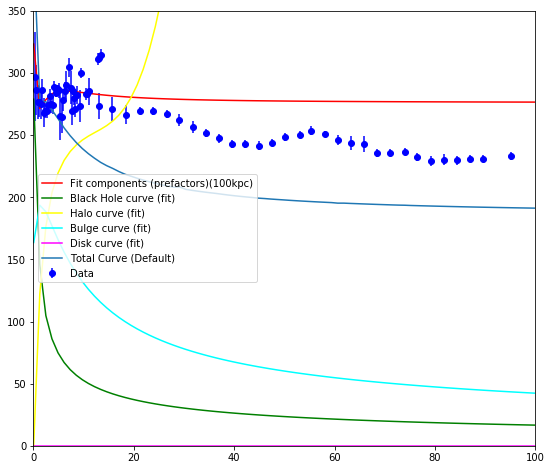

In [13]:
#Plot each fitted component to 100kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,100)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(r_plot_zoom,g_curve_zoom,'r-',label='Fit components (prefactors)(100kpc)')
plt.plot(r_plot_zoom,bh_curve_zoom,'green',label='Black Hole curve (fit)')
plt.plot(r_plot_zoom,halo_curve_zoom,'yellow',label='Halo curve (fit)')
plt.plot(r_plot_zoom,bulge_curve_zoom,'cyan',label='Bulge curve (fit)')
plt.plot(r_plot_zoom,disk_curve_zoom,'magenta',label='Disk curve (fit)')

plt.plot(r_plot_zoom,g(r_plot_zoom,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,0.1),label='Total Curve (Default)')

plt.legend()
plt.savefig('ANV_Fitting_allcomponents_100kpc.png')
plt.show()

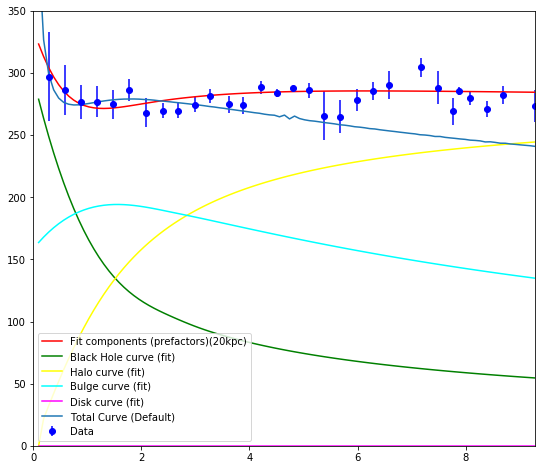

In [14]:
#Plot each fitted component to 20kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,r_dat[Npts-1])
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(r_plot,g_curve,'r-',label='Fit components (prefactors)(20kpc)')
plt.plot(r_plot,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(r_plot,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(r_plot,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(r_plot,disk_curve,'magenta',label='Disk curve (fit)')

plt.plot(r_plot,g(r_plot,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,0.1),label='Total Curve (Default)')

plt.legend()
plt.savefig('ANV_Fitting_allcomponents_2kpc.png')
plt.show()

In [15]:
# Explanation of parameters 

# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(g_c))

print('')


# Disk
print('Disk')
print('Scaling constant,         prefactor = {:.3f}'.format(g_pref))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(g_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(g_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(g_rc))


Bulge
Scaling constant,         C = 0.78

Disk
Scaling constant,         prefactor = 0.000

Black Hole
Mass of the Black Hole,   M(bh) = 6.434e+09 [solar masses]

Dark Halo
Halo central density,     rho00 = 7.184e+08 [solar mass/kpc^3]
Core radius,              rc = 1.40 [kpc]


In [16]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
3.739546060562134 seconds

Timestamp:
2019-11-08 11:47:30.413446
